# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

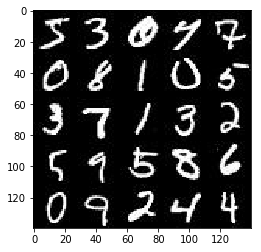

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

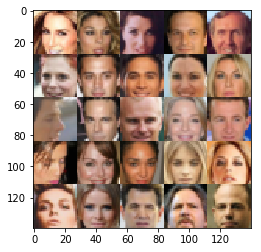

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learn_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = tf.layers.conv2d(x1, 128, 5, 2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 x 7 x 128
        
        x3 = tf.layers.conv2d(x2, 256, 5, 1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7 x 7 x 256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14 x 14 x 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28 x 28 x 128

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 1, padding='same')
        # 28 x 28 x 3

        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    losses = []
    #tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                #endif 
                    
                if steps % 50 == 0:
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                #endif
            #end for batch_images
        #end for epoch_i
    #end with
           
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0044... Generator Loss: 5.5499
Epoch 1/2... Discriminator Loss: 0.0821... Generator Loss: 19.2557
Epoch 1/2... Discriminator Loss: 0.0231... Generator Loss: 25.5104
Epoch 1/2... Discriminator Loss: 0.0242... Generator Loss: 13.0615
Epoch 1/2... Discriminator Loss: 0.1027... Generator Loss: 3.0773


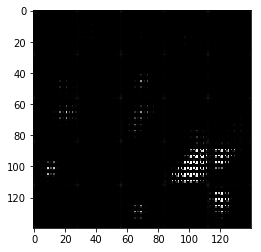

Epoch 1/2... Discriminator Loss: 0.0148... Generator Loss: 4.9325
Epoch 1/2... Discriminator Loss: 0.2193... Generator Loss: 2.8915
Epoch 1/2... Discriminator Loss: 0.0197... Generator Loss: 6.4024
Epoch 1/2... Discriminator Loss: 0.0147... Generator Loss: 5.6671
Epoch 1/2... Discriminator Loss: 0.0113... Generator Loss: 5.0670


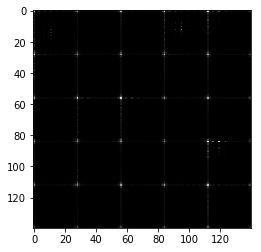

Epoch 1/2... Discriminator Loss: 0.0111... Generator Loss: 5.5174
Epoch 1/2... Discriminator Loss: 0.0203... Generator Loss: 4.6518
Epoch 1/2... Discriminator Loss: 15.4115... Generator Loss: 18.5879
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 1.3221
Epoch 1/2... Discriminator Loss: 0.7827... Generator Loss: 2.1883


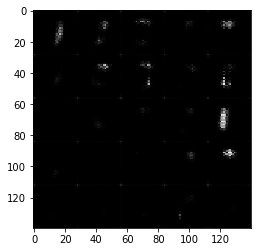

Epoch 1/2... Discriminator Loss: 0.7349... Generator Loss: 1.4159
Epoch 1/2... Discriminator Loss: 1.3628... Generator Loss: 3.7278
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 2.9449
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 2.6686
Epoch 1/2... Discriminator Loss: 0.8500... Generator Loss: 2.3484


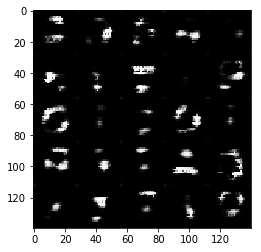

Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 1.5287... Generator Loss: 0.5525
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 1.4430
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 0.9850
Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 1.2760


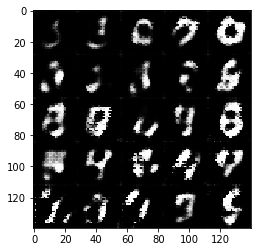

Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 2.1627
Epoch 1/2... Discriminator Loss: 1.2500... Generator Loss: 0.6490
Epoch 1/2... Discriminator Loss: 2.1340... Generator Loss: 2.2250
Epoch 1/2... Discriminator Loss: 1.2581... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 1.6531... Generator Loss: 0.4754


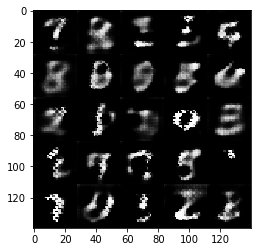

Epoch 1/2... Discriminator Loss: 1.6957... Generator Loss: 0.6018
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.4824
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 1.1579
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.0632... Generator Loss: 1.0293


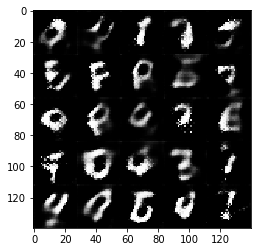

Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 0.5412
Epoch 1/2... Discriminator Loss: 1.2490... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 1.1966
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.4771... Generator Loss: 0.4673


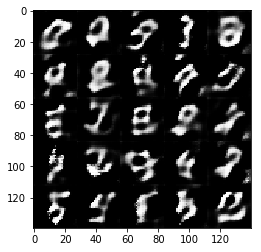

Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 1.4117
Epoch 1/2... Discriminator Loss: 1.6249... Generator Loss: 1.4635
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.7345
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.5379
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.5911


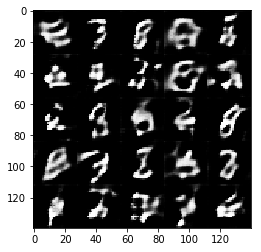

Epoch 1/2... Discriminator Loss: 1.2671... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 0.9654
Epoch 1/2... Discriminator Loss: 1.1075... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 1.0115
Epoch 1/2... Discriminator Loss: 1.0850... Generator Loss: 1.1397


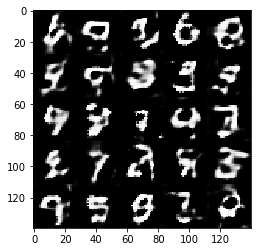

Epoch 1/2... Discriminator Loss: 1.1715... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.5998
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.9686
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 1.0502


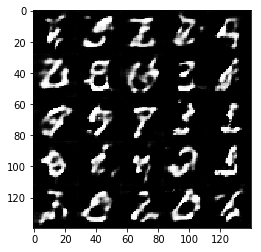

Epoch 1/2... Discriminator Loss: 1.4949... Generator Loss: 0.4338
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.6940
Epoch 1/2... Discriminator Loss: 1.5448... Generator Loss: 0.3639
Epoch 1/2... Discriminator Loss: 1.4515... Generator Loss: 1.4887


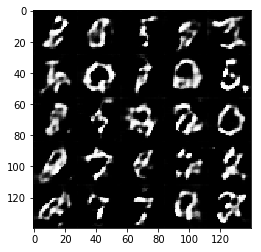

Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 0.9925
Epoch 1/2... Discriminator Loss: 1.1593... Generator Loss: 0.9821
Epoch 1/2... Discriminator Loss: 1.1794... Generator Loss: 0.7179
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 0.9295
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 0.7296


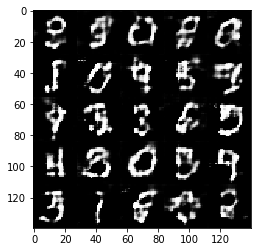

Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 0.9071
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.7696
Epoch 1/2... Discriminator Loss: 1.0674... Generator Loss: 0.8580
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.7283


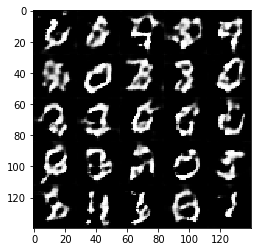

Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 1.0302
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 1.3673
Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 0.7128


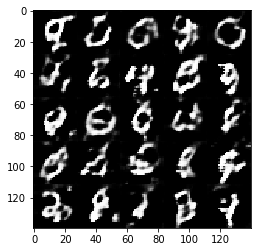

Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.7904
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 0.8632
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 1.2435
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 0.6727


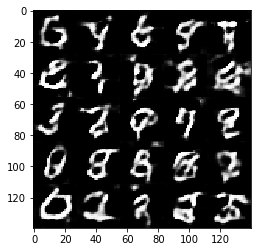

Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 0.9941
Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 0.7925
Epoch 1/2... Discriminator Loss: 1.0780... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 0.9727
Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 0.8843


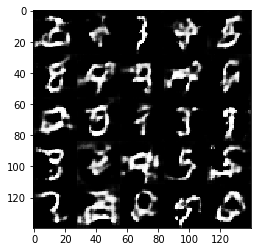

Epoch 1/2... Discriminator Loss: 2.0690... Generator Loss: 0.4592
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 1.1828
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 1.0626
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.1675
Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 1.1069


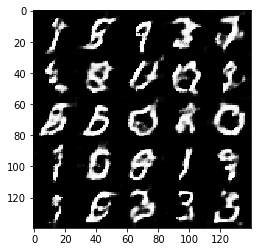

Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 0.6557
Epoch 1/2... Discriminator Loss: 1.0379... Generator Loss: 0.9910
Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 0.9200
Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 0.7665
Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 0.8871


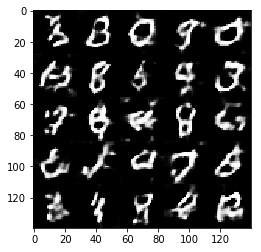

Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.8338
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 0.8385
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 1.6254
Epoch 2/2... Discriminator Loss: 1.1067... Generator Loss: 0.8706


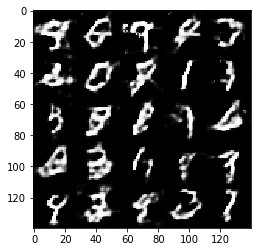

Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 0.8873
Epoch 2/2... Discriminator Loss: 1.1342... Generator Loss: 1.0325
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 0.7404
Epoch 2/2... Discriminator Loss: 1.2101... Generator Loss: 0.9042
Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 1.1812


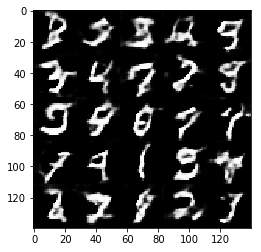

Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.6547
Epoch 2/2... Discriminator Loss: 1.3557... Generator Loss: 0.5265
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 0.4319
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 0.7047


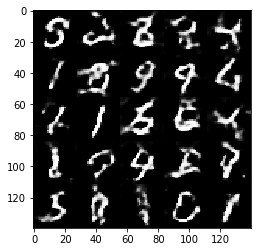

Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 1.2015
Epoch 2/2... Discriminator Loss: 1.1962... Generator Loss: 1.2581
Epoch 2/2... Discriminator Loss: 1.1566... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 0.8819
Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 0.8063


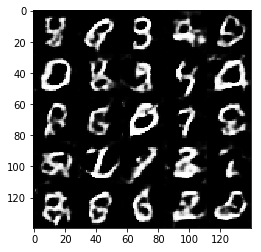

Epoch 2/2... Discriminator Loss: 1.1649... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.2025... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 1.4113... Generator Loss: 0.4801
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.6010
Epoch 2/2... Discriminator Loss: 1.2877... Generator Loss: 0.5870


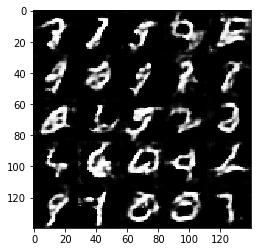

Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 1.2430... Generator Loss: 1.1079
Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 1.0129
Epoch 2/2... Discriminator Loss: 1.2644... Generator Loss: 0.9077


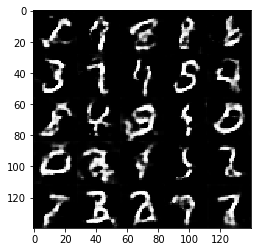

Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.9870
Epoch 2/2... Discriminator Loss: 1.1622... Generator Loss: 0.7797
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.1192... Generator Loss: 1.1589
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 1.1404


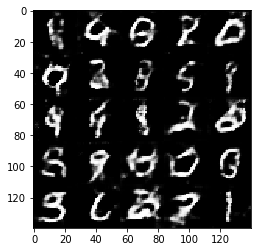

Epoch 2/2... Discriminator Loss: 1.2987... Generator Loss: 0.5352
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 1.0355
Epoch 2/2... Discriminator Loss: 1.1957... Generator Loss: 1.0745
Epoch 2/2... Discriminator Loss: 1.2431... Generator Loss: 0.8945
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 1.0153


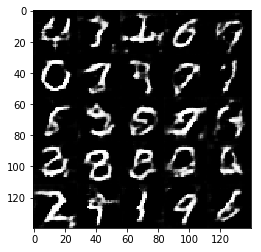

Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.5494
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 1.1055
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 0.8495
Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.7059


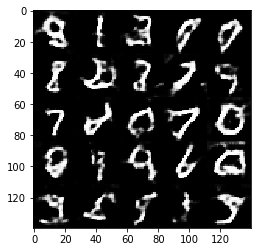

Epoch 2/2... Discriminator Loss: 1.2169... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 0.8386
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 0.8938
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.9240


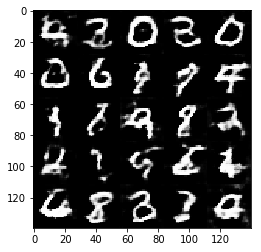

Epoch 2/2... Discriminator Loss: 1.3066... Generator Loss: 0.7427
Epoch 2/2... Discriminator Loss: 1.3201... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.7503
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.6272
Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 0.9843


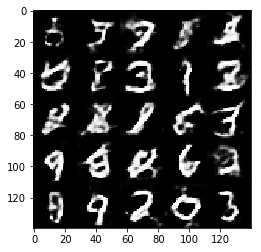

Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.6000
Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.1280... Generator Loss: 1.0708
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.9148


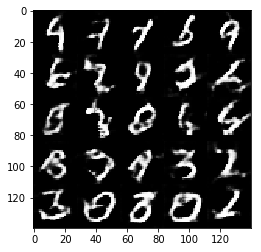

Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.6411
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.7616
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 1.0991
Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.5797
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.6228


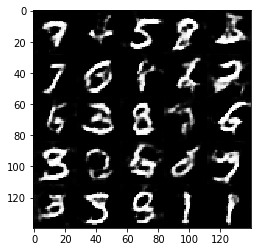

Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.9575
Epoch 2/2... Discriminator Loss: 1.1823... Generator Loss: 1.2822
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.9693
Epoch 2/2... Discriminator Loss: 1.2393... Generator Loss: 0.7879
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 1.2532


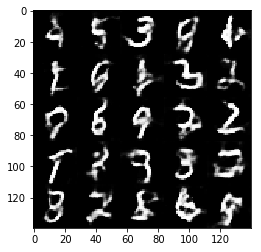

Epoch 2/2... Discriminator Loss: 1.1647... Generator Loss: 0.9503
Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 0.7708
Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 1.1867
Epoch 2/2... Discriminator Loss: 1.2794... Generator Loss: 0.9051
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.9415


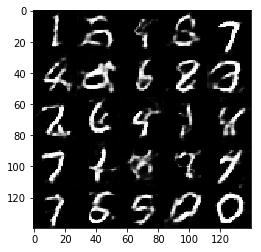

Epoch 2/2... Discriminator Loss: 1.1649... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.7206
Epoch 2/2... Discriminator Loss: 1.3266... Generator Loss: 0.6052
Epoch 2/2... Discriminator Loss: 1.3591... Generator Loss: 1.2811
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 1.1266


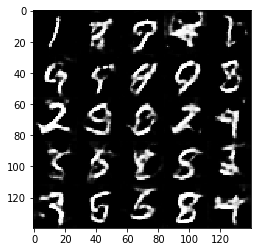

Epoch 2/2... Discriminator Loss: 1.1501... Generator Loss: 1.1157
Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 1.2099... Generator Loss: 0.7212
Epoch 2/2... Discriminator Loss: 1.2552... Generator Loss: 0.5150
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.9035


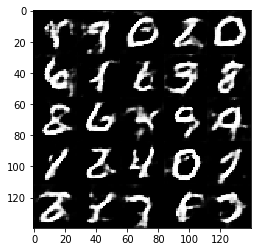

Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 0.9909
Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 1.1954


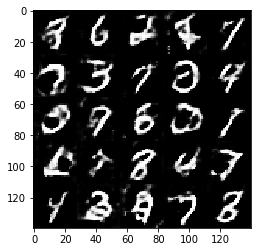

Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 0.7887
Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 0.8176


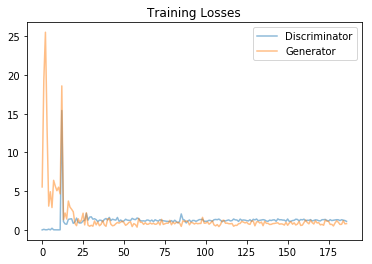

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0075... Generator Loss: 12.2811
Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 10.8726
Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 21.5955
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 22.3365
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 18.1538


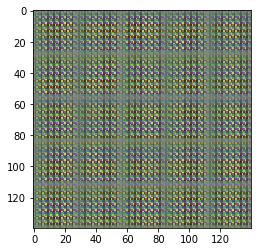

Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 24.4126
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 23.1095
Epoch 1/1... Discriminator Loss: 0.0311... Generator Loss: 25.3313
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 21.8272
Epoch 1/1... Discriminator Loss: 0.1494... Generator Loss: 4.2702


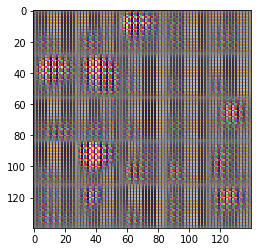

Epoch 1/1... Discriminator Loss: 0.0373... Generator Loss: 4.5428
Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 5.6890
Epoch 1/1... Discriminator Loss: 0.2683... Generator Loss: 4.9828
Epoch 1/1... Discriminator Loss: 0.2648... Generator Loss: 2.4142
Epoch 1/1... Discriminator Loss: 4.7349... Generator Loss: 0.2029


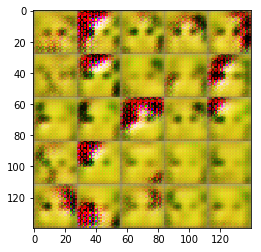

Epoch 1/1... Discriminator Loss: 3.2697... Generator Loss: 0.1900
Epoch 1/1... Discriminator Loss: 2.6955... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 2.1005... Generator Loss: 0.3515
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 0.7184... Generator Loss: 2.2839


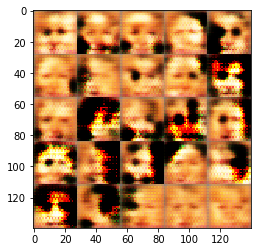

Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.5020
Epoch 1/1... Discriminator Loss: 0.3228... Generator Loss: 2.3877
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.8137
Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 2.4837
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 1.5720


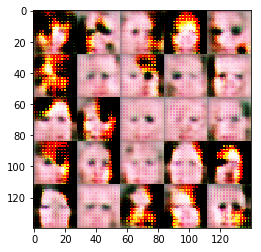

Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 4.1128
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 3.0313
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 2.2485


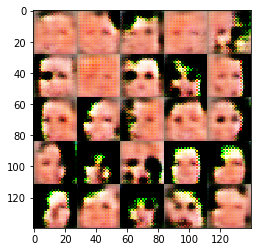

Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 2.9347
Epoch 1/1... Discriminator Loss: 0.3609... Generator Loss: 1.6409
Epoch 1/1... Discriminator Loss: 0.3402... Generator Loss: 2.6235
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.4154


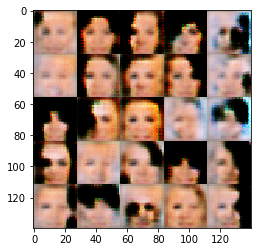

Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.5838
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 1.2373
Epoch 1/1... Discriminator Loss: 1.9722... Generator Loss: 4.3582
Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 1.9099
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.3178


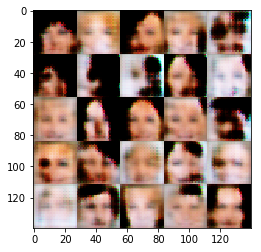

Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 1.6070
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.4620


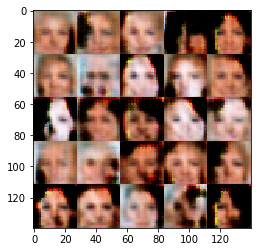

Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 1.5499
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 1.9463
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.8170
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 2.4189


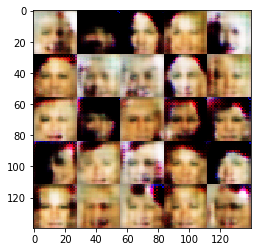

Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 1.5327


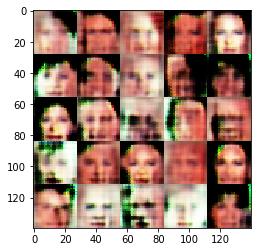

Epoch 1/1... Discriminator Loss: 0.5998... Generator Loss: 2.1864
Epoch 1/1... Discriminator Loss: 0.2336... Generator Loss: 3.2728
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.6585


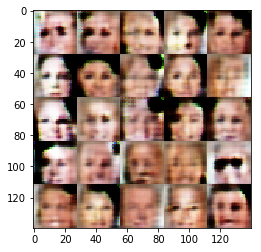

Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 1.1661
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 2.0894
Epoch 1/1... Discriminator Loss: 2.1629... Generator Loss: 0.1909
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.5969


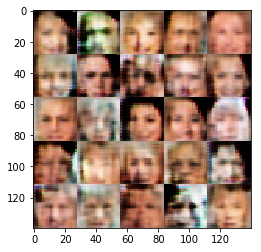

Epoch 1/1... Discriminator Loss: 2.0436... Generator Loss: 0.2061
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.8430
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.7501


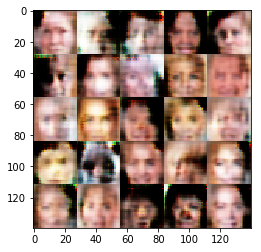

Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.6630
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 2.1075
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 1.7489
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.2950
Epoch 1/1... Discriminator Loss: 1.5554... Generator Loss: 0.3769


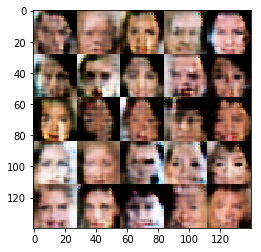

Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.3277
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.4160
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 2.5625
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.5615


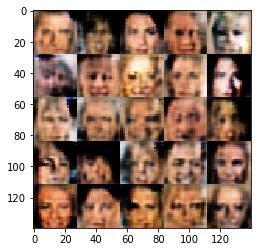

Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.4225
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 2.8542


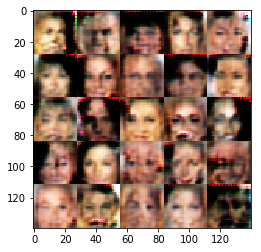

Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 0.6790... Generator Loss: 2.0378
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.9167
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 0.9546


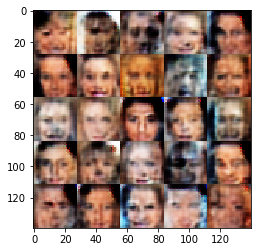

Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.8516


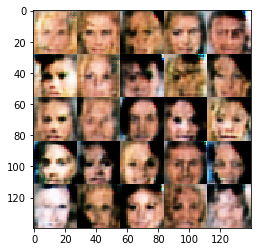

Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.8259
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 1.4571


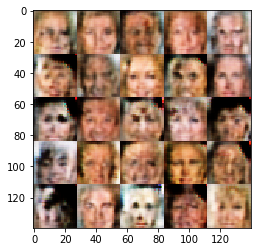

Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.4117
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.7938


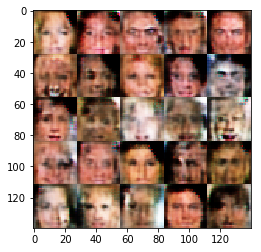

Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.4259
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 0.8386


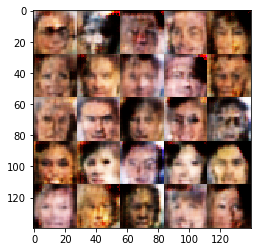

Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.1877
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.3736
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.3342
Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 1.3487


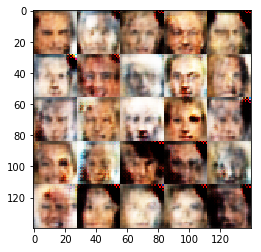

Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 2.3690
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.9428


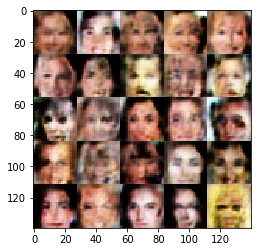

Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.8888
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.3899
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.6351


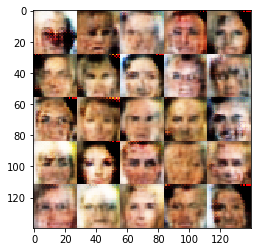

Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.3832
Epoch 1/1... Discriminator Loss: 1.6005... Generator Loss: 2.4590
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.8818... Generator Loss: 3.6682


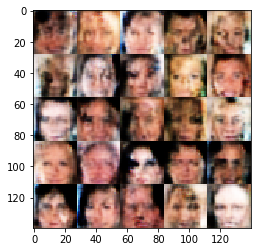

Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.4168


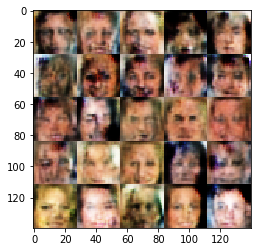

Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 1.8605
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 1.4132
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 1.6849
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.8061


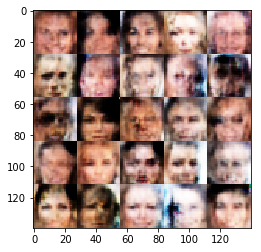

Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.8514
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 3.1226
Epoch 1/1... Discriminator Loss: 0.2179... Generator Loss: 2.6706
Epoch 1/1... Discriminator Loss: 0.2024... Generator Loss: 2.7200


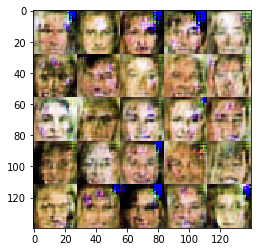

Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 1.4217
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.2386
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 1.3219


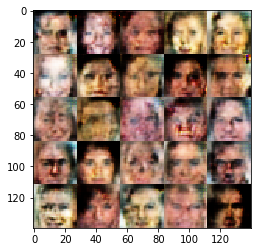

Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 2.2558
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.4722


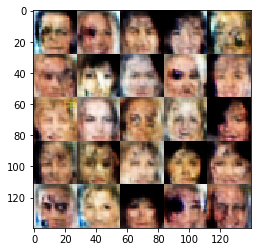

Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.5040
Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 0.3641
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.2956


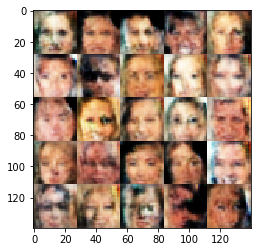

Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.4333
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 0.8479


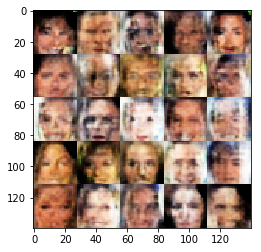

Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 3.2603
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.2694
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.5150


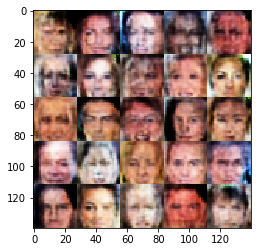

Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.8768
Epoch 1/1... Discriminator Loss: 2.8080... Generator Loss: 4.3939
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.9939
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.6727


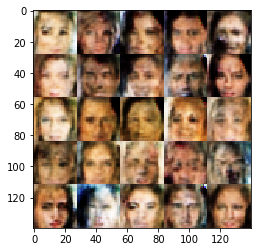

Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.4830
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 1.9498
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.1572


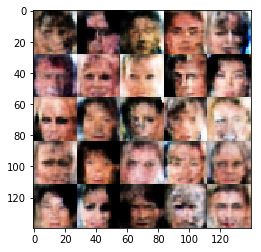

Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 1.5389
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.0637


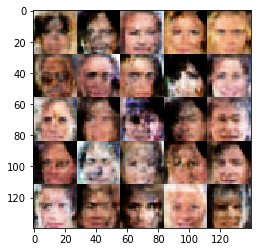

Epoch 1/1... Discriminator Loss: 1.6354... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.7806... Generator Loss: 2.9920


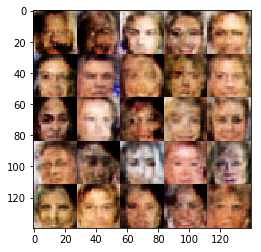

Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 1.9060
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.9230


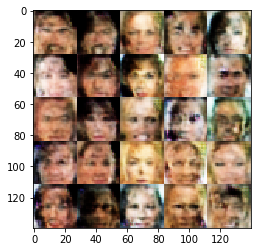

Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 2.2916
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 0.9185


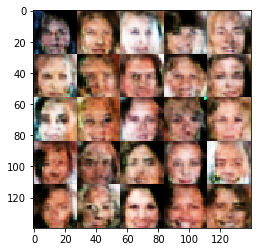

Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.3575
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.4834
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 1.0578


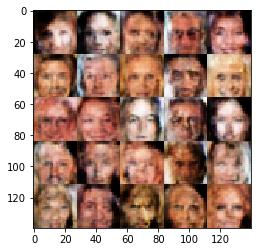

Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.3873
Epoch 1/1... Discriminator Loss: 1.6925... Generator Loss: 2.1979
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.8359


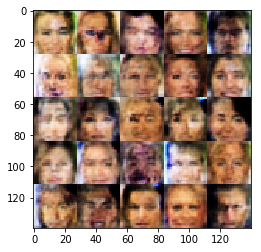

Epoch 1/1... Discriminator Loss: 2.4405... Generator Loss: 3.8092
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 2.0870
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.3904


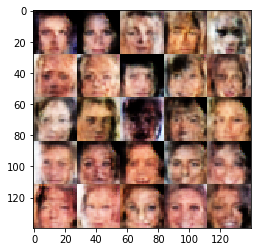

Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.7256


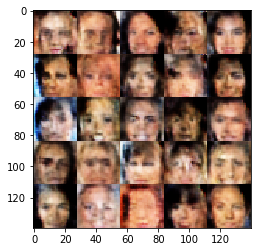

Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 0.3847
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.8153
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5400


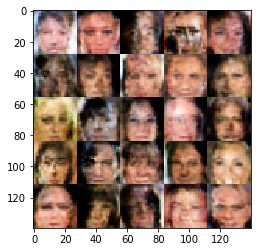

Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.2274


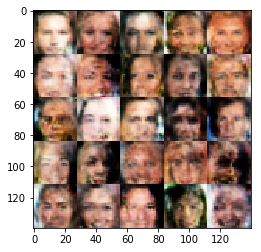

Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.4014
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.4612
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.7670


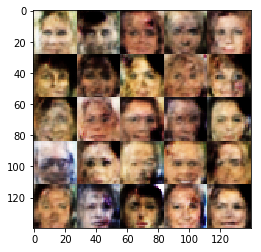

Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 0.9597


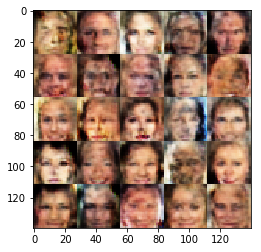

Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.5776
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.9330


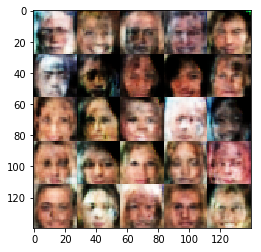

Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.7617... Generator Loss: 0.3292


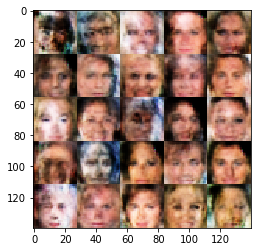

Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 1.0893


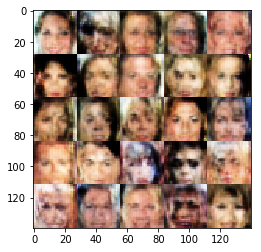

Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 1.0962
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 1.8111
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.6294


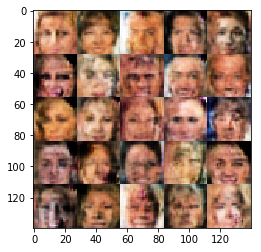

Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.5173
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.7740


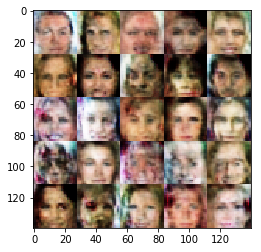

Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 1.8051
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 0.9144


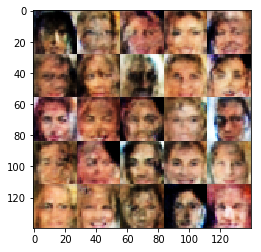

Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.7279
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 1.2978
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.0810


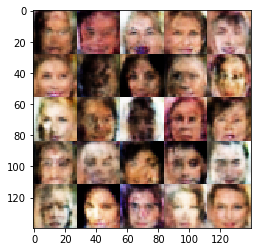

Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.3959
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.3967


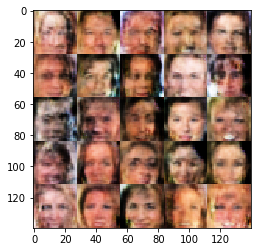

Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.5674
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 1.4027
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 1.2536


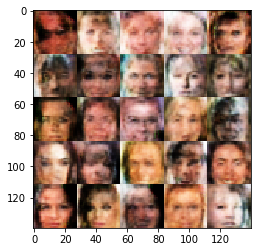

Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 1.6891
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.7135


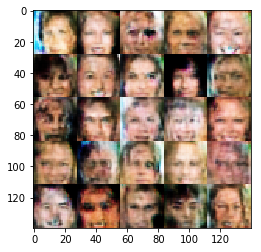

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.4692
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 2.1037
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.3962
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.7649


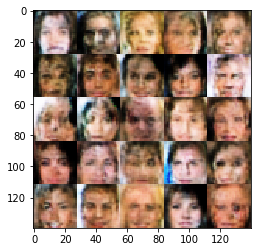

Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 2.2471
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.0211


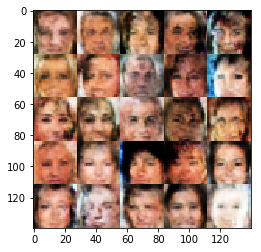

Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.4833
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 1.3600
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.0209


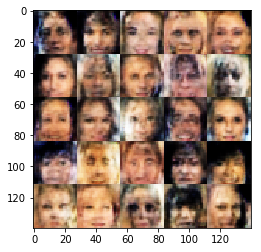

Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 2.3794
Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 1.6585
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 1.9483
Epoch 1/1... Discriminator Loss: 0.1228... Generator Loss: 2.9857


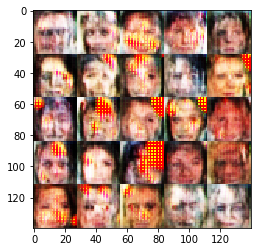

Epoch 1/1... Discriminator Loss: 0.1265... Generator Loss: 3.2904
Epoch 1/1... Discriminator Loss: 0.2580... Generator Loss: 2.1731
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 1.4898
Epoch 1/1... Discriminator Loss: 0.1657... Generator Loss: 2.5956
Epoch 1/1... Discriminator Loss: 0.1014... Generator Loss: 3.3859


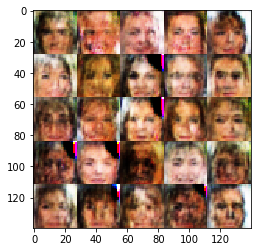

Epoch 1/1... Discriminator Loss: 0.2841... Generator Loss: 1.9769


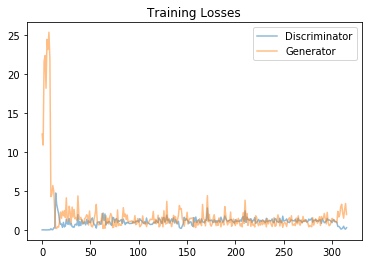

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Cars

cars
Epoch 1/3... Discriminator Loss: 0.0362... Generator Loss: 10.5174
Epoch 1/3... Discriminator Loss: 0.0973... Generator Loss: 22.7188
Epoch 1/3... Discriminator Loss: 0.0515... Generator Loss: 23.2357
Epoch 1/3... Discriminator Loss: 10.8724... Generator Loss: 0.0000
Epoch 1/3... Discriminator Loss: 0.3351... Generator Loss: 11.3768


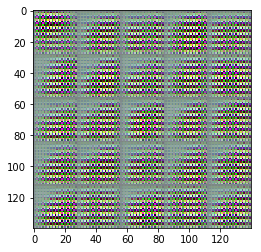

Epoch 1/3... Discriminator Loss: 0.0803... Generator Loss: 4.6312
Epoch 1/3... Discriminator Loss: 0.1837... Generator Loss: 9.5994
Epoch 1/3... Discriminator Loss: 0.1509... Generator Loss: 2.7675
Epoch 1/3... Discriminator Loss: 0.0655... Generator Loss: 3.8874
Epoch 1/3... Discriminator Loss: 0.0641... Generator Loss: 3.7172


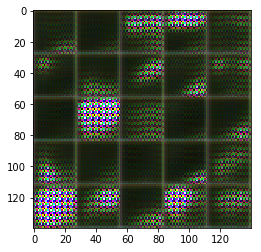

Epoch 1/3... Discriminator Loss: 0.1278... Generator Loss: 3.1183
Epoch 1/3... Discriminator Loss: 0.2310... Generator Loss: 2.8687
Epoch 1/3... Discriminator Loss: 0.0645... Generator Loss: 3.6975
Epoch 1/3... Discriminator Loss: 0.1426... Generator Loss: 2.7291
Epoch 1/3... Discriminator Loss: 0.0455... Generator Loss: 4.3034


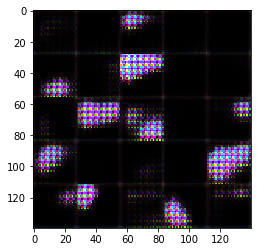

Epoch 1/3... Discriminator Loss: 0.1707... Generator Loss: 2.5202
Epoch 1/3... Discriminator Loss: 0.7615... Generator Loss: 3.0680
Epoch 1/3... Discriminator Loss: 0.7159... Generator Loss: 1.5138
Epoch 1/3... Discriminator Loss: 1.4072... Generator Loss: 0.7903
Epoch 1/3... Discriminator Loss: 0.3504... Generator Loss: 1.9376


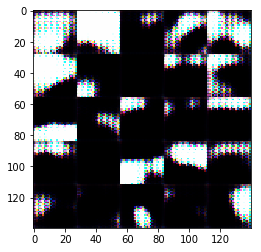

Epoch 1/3... Discriminator Loss: 0.1714... Generator Loss: 2.7796
Epoch 1/3... Discriminator Loss: 0.1226... Generator Loss: 2.9715
Epoch 1/3... Discriminator Loss: 0.1299... Generator Loss: 5.3666
Epoch 1/3... Discriminator Loss: 0.8150... Generator Loss: 1.6571
Epoch 1/3... Discriminator Loss: 0.3879... Generator Loss: 1.9649


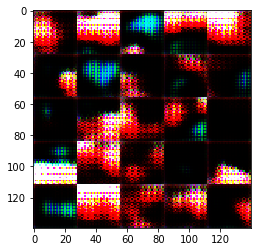

Epoch 2/3... Discriminator Loss: 0.7924... Generator Loss: 0.9160
Epoch 2/3... Discriminator Loss: 0.8409... Generator Loss: 1.3812
Epoch 2/3... Discriminator Loss: 0.8289... Generator Loss: 1.0525
Epoch 2/3... Discriminator Loss: 0.6640... Generator Loss: 1.2165
Epoch 2/3... Discriminator Loss: 0.6212... Generator Loss: 1.0858


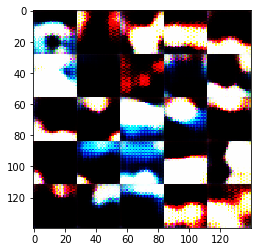

Epoch 2/3... Discriminator Loss: 0.5825... Generator Loss: 2.3210
Epoch 2/3... Discriminator Loss: 0.7048... Generator Loss: 1.4720
Epoch 2/3... Discriminator Loss: 0.6501... Generator Loss: 1.0530
Epoch 2/3... Discriminator Loss: 1.6685... Generator Loss: 5.1251
Epoch 2/3... Discriminator Loss: 1.5462... Generator Loss: 0.4282


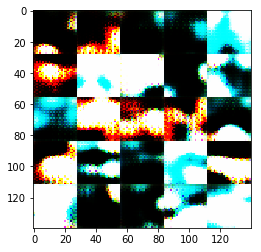

Epoch 2/3... Discriminator Loss: 0.8907... Generator Loss: 0.7322
Epoch 2/3... Discriminator Loss: 2.0689... Generator Loss: 4.9906
Epoch 2/3... Discriminator Loss: 0.2985... Generator Loss: 3.6554
Epoch 2/3... Discriminator Loss: 0.4033... Generator Loss: 3.2989
Epoch 2/3... Discriminator Loss: 1.6065... Generator Loss: 0.4103


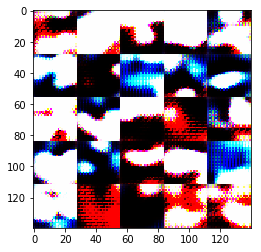

Epoch 2/3... Discriminator Loss: 0.3129... Generator Loss: 2.3433
Epoch 2/3... Discriminator Loss: 0.2125... Generator Loss: 2.6789
Epoch 2/3... Discriminator Loss: 0.7393... Generator Loss: 0.8717
Epoch 2/3... Discriminator Loss: 0.4293... Generator Loss: 1.9918
Epoch 2/3... Discriminator Loss: 1.0268... Generator Loss: 0.7248


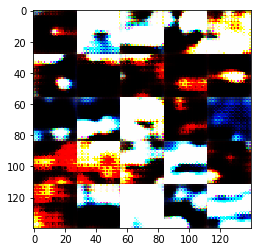

Epoch 2/3... Discriminator Loss: 0.5201... Generator Loss: 3.1190
Epoch 2/3... Discriminator Loss: 0.3555... Generator Loss: 2.6259
Epoch 2/3... Discriminator Loss: 0.6839... Generator Loss: 1.1282
Epoch 2/3... Discriminator Loss: 0.9831... Generator Loss: 0.9189
Epoch 2/3... Discriminator Loss: 0.4781... Generator Loss: 1.5216


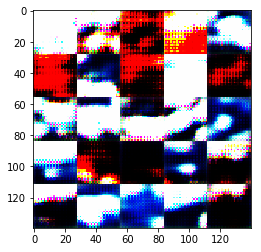

Epoch 3/3... Discriminator Loss: 0.7470... Generator Loss: 1.1980
Epoch 3/3... Discriminator Loss: 0.6935... Generator Loss: 4.3898
Epoch 3/3... Discriminator Loss: 1.0357... Generator Loss: 0.8687
Epoch 3/3... Discriminator Loss: 0.0441... Generator Loss: 4.5692
Epoch 3/3... Discriminator Loss: 0.6525... Generator Loss: 1.1959


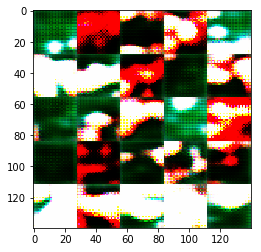

Epoch 3/3... Discriminator Loss: 2.5689... Generator Loss: 0.1457
Epoch 3/3... Discriminator Loss: 0.1344... Generator Loss: 2.5504
Epoch 3/3... Discriminator Loss: 0.3193... Generator Loss: 2.2697
Epoch 3/3... Discriminator Loss: 0.2865... Generator Loss: 1.9886
Epoch 3/3... Discriminator Loss: 0.6162... Generator Loss: 1.1071


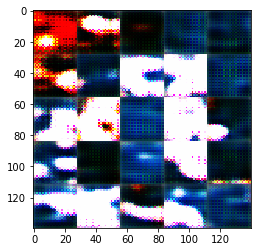

Epoch 3/3... Discriminator Loss: 4.0066... Generator Loss: 9.3507
Epoch 3/3... Discriminator Loss: 1.7542... Generator Loss: 0.5120
Epoch 3/3... Discriminator Loss: 0.2681... Generator Loss: 3.1133
Epoch 3/3... Discriminator Loss: 0.7975... Generator Loss: 0.9467
Epoch 3/3... Discriminator Loss: 0.9148... Generator Loss: 1.4586


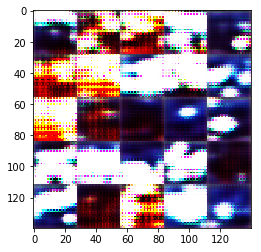

Epoch 3/3... Discriminator Loss: 1.6468... Generator Loss: 6.1410
Epoch 3/3... Discriminator Loss: 0.6402... Generator Loss: 1.4069
Epoch 3/3... Discriminator Loss: 0.2712... Generator Loss: 2.6132
Epoch 3/3... Discriminator Loss: 0.4432... Generator Loss: 2.3290
Epoch 3/3... Discriminator Loss: 0.9473... Generator Loss: 5.5864


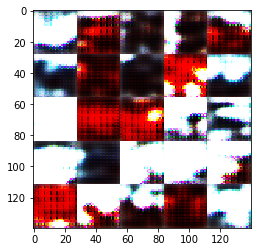

Epoch 3/3... Discriminator Loss: 0.4780... Generator Loss: 3.1106
Epoch 3/3... Discriminator Loss: 1.1940... Generator Loss: 0.4738
Epoch 3/3... Discriminator Loss: 1.8074... Generator Loss: 0.6061
Epoch 3/3... Discriminator Loss: 0.7228... Generator Loss: 1.1794
Epoch 3/3... Discriminator Loss: 1.2656... Generator Loss: 2.2419


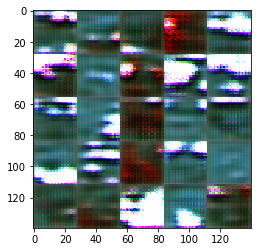

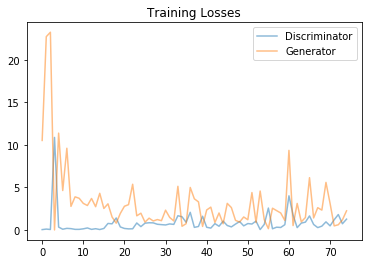

In [13]:
batch_size = 64
z_dim = 150
learning_rate = 0.0005
beta1 = 0.5

import helper

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

cars_dataset = helper.Dataset('cars', glob(os.path.join(data_dir, 'cars/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, cars_dataset.get_batches,
          cars_dataset.shape, cars_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.